In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import json
import os
import joblib

from catboost import CatBoostClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from imblearn.over_sampling import SMOTE

In [15]:
# ==== 设置路径 ====
excel_dir = r'F:\codes\00-WORK\work-1\01-myself\01-predict\03-classification\EXCEL'
param_dir = os.getcwd()  # 当前工作目录
# 模型保存目录
# 模型保存目录
model_dir = r"F:\codes\00-WORK\work-1\01-myself\01-predict\01-model"
os.makedirs(model_dir, exist_ok=True)

# 象限标签
# 象限和文件映射
quadrants = ['++', '-+', '--', '+-']
model_names = ['I', 'II', 'III', 'IV']  # 用中文序号命名

excel_files = [os.path.join(excel_dir, f"{q}_MatImputer.xlsx") for q in quadrants]
param_files = [os.path.join(param_dir, f"{q}_best_params.json") for q in quadrants]

In [16]:
# ==== 加载数据和超参数 ====
dfs = [pd.read_excel(file) for file in excel_files]
param_map = {}

for q, pf in zip(quadrants, param_files):
    with open(pf, 'r') as f:
        param_map[q] = json.load(f)


In [17]:
# 保存最佳超参数到文件
def load_data(quadrant):
    filepath = f"{excel_dir}\\{quadrant}_MatImputer.xlsx"
    df = pd.read_excel(filepath)
    X = df.drop(columns=['classification'])
    y = df['classification']
    return X, y

def load_params(quadrant):
    filepath = f"{param_dir}\\{quadrant}_best_params.json"
    with open(filepath, 'r') as f:
        params = json.load(f)
    return params

In [18]:
# 计算各类指标
def evaluate_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    return acc, prec, rec, f1

# 交叉验证
def run_cv(X, y, params, n_splits=3, random_state=42):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    mean_fpr = np.linspace(0, 1, 100)

    tprs, aucs, fold_metrics = [], [], []
    all_y_val, all_y_pred_val, all_y_prob_val = [], [], []

    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X), start=1):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        smote = SMOTE(random_state=random_state)
        X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

        model = CatBoostClassifier(**params, random_state=random_state, verbose=0)
        model.fit(X_train_res, y_train_res)

        y_pred = model.predict(X_val)
        y_prob = model.predict_proba(X_val)[:, 1]

        acc, prec, rec, f1 = evaluate_metrics(y_val, y_pred)
        fpr, tpr, _ = roc_curve(y_val, y_prob)
        roc_auc = auc(fpr, tpr)

        fold_metrics.append({
            'fold': fold_idx,
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1,
            'auc': roc_auc,
            'fpr': fpr.tolist(),
            'tpr': tpr.tolist()
        })

        all_y_val.extend(y_val)
        all_y_pred_val.extend(y_pred)
        all_y_prob_val.append(y_prob)

        aucs.append(roc_auc)
        tpr_interp = np.interp(mean_fpr, fpr, tpr)
        tpr_interp[0] = 0.0
        tprs.append(tpr_interp)

    mean_tpr = np.mean(tprs, axis=0)
    std_auc = np.std(aucs)
    mean_auc = np.mean(aucs)

    all_y_prob_val = np.concatenate(all_y_prob_val)
    fpr_all, tpr_all, _ = roc_curve(all_y_val, all_y_prob_val)
    auc_all = auc(fpr_all, tpr_all)

    cm = confusion_matrix(all_y_val, all_y_pred_val)

    accuracy_list = [m['accuracy'] for m in fold_metrics]
    precision_list = [m['precision'] for m in fold_metrics]
    recall_list = [m['recall'] for m in fold_metrics]
    f1_list = [m['f1'] for m in fold_metrics]
    auc_list = [m['auc'] for m in fold_metrics]

    metrics_summary = {
        'accuracy_mean': np.mean(accuracy_list),
        'accuracy_std': np.std(accuracy_list),
        'precision_mean': np.mean(precision_list),
        'precision_std': np.std(precision_list),
        'recall_mean': np.mean(recall_list),
        'recall_std': np.std(recall_list),
        'f1_mean': np.mean(f1_list),
        'f1_std': np.std(f1_list),
        'auc_mean': np.mean(auc_list),
        'auc_std': np.std(auc_list)
    }

    return {
        'fold_metrics': fold_metrics,
        'metrics_summary': metrics_summary,
        'mean_fpr': mean_fpr,
        'mean_tpr': mean_tpr,
        'mean_auc': mean_auc,
        'std_auc': std_auc,
        'fpr_all': fpr_all,
        'tpr_all': tpr_all,
        'auc_all': auc_all,
        'confusion_matrix': cm
    }

def metrics_df_with_mean(fold_metrics):
    df = pd.DataFrame(fold_metrics)
    mean_row = df.mean(numeric_only=True)
    mean_row['fold'] = 'Mean'
    df = pd.concat([df, mean_row.to_frame().T], ignore_index=True)
    return df


In [19]:
# ==== 主循环 ====
results_all = {}

for q, model_name in zip(quadrants, model_names):
    print(f"== 处理象限 {q} ==")
    X, y = load_data(q)
    params = load_params(q)
    res = run_cv(X, y, params)
    results_all[q] = res

    # 输出指标
    for fm in res['fold_metrics']:
        print(f"  Fold {fm['fold']} - Acc: {fm['accuracy']:.2f}, Prec: {fm['precision']:.2f}, "
              f"Rec: {fm['recall']:.2f}, F1: {fm['f1']:.2f}, AUC: {fm['auc']:.2f}")
    print(f"  全集AUC: {res['auc_all']:.2f}")

    # ✅ 训练完整数据的最终模型并保存
    final_model = CatBoostClassifier(**params, random_state=42, verbose=0)
    final_model.fit(X, y)
    save_path = os.path.join(model_dir, f"{model_name}.joblib")
    joblib.dump(final_model, save_path)
    print(f"✅ 模型已保存: {save_path}")

== 处理象限 ++ ==
  Fold 1 - Acc: 0.89, Prec: 0.89, Rec: 0.89, F1: 0.89, AUC: 0.96
  Fold 2 - Acc: 0.93, Prec: 0.93, Rec: 0.93, F1: 0.93, AUC: 0.94
  Fold 3 - Acc: 0.89, Prec: 0.89, Rec: 0.89, F1: 0.89, AUC: 0.90
  全集AUC: 0.93
✅ 模型已保存: F:\codes\00-WORK\work-1\01-myself\01-predict\01-model\I.joblib
== 处理象限 -+ ==
  Fold 1 - Acc: 0.91, Prec: 0.91, Rec: 0.91, F1: 0.91, AUC: 0.97
  Fold 2 - Acc: 0.96, Prec: 0.97, Rec: 0.96, F1: 0.96, AUC: 0.92
  Fold 3 - Acc: 0.95, Prec: 0.94, Rec: 0.95, F1: 0.95, AUC: 0.91
  全集AUC: 0.93
✅ 模型已保存: F:\codes\00-WORK\work-1\01-myself\01-predict\01-model\II.joblib
== 处理象限 -- ==
  Fold 1 - Acc: 0.80, Prec: 0.82, Rec: 0.80, F1: 0.81, AUC: 0.90
  Fold 2 - Acc: 0.80, Prec: 0.81, Rec: 0.80, F1: 0.81, AUC: 0.89
  Fold 3 - Acc: 0.93, Prec: 0.93, Rec: 0.93, F1: 0.93, AUC: 0.95
  全集AUC: 0.91
✅ 模型已保存: F:\codes\00-WORK\work-1\01-myself\01-predict\01-model\III.joblib
== 处理象限 +- ==
  Fold 1 - Acc: 0.84, Prec: 0.83, Rec: 0.84, F1: 0.83, AUC: 0.88
  Fold 2 - Acc: 0.88, Prec: 0.89,

In [20]:
# ==== 汇总平均指标 ====
rows = []
for q, name in zip(quadrants, model_names):
    summary = results_all[q]['metrics_summary']
    rows.append({
        'Quadrant': name,
        'accuracy_mean': summary['accuracy_mean'],
        'precision_mean': summary['precision_mean'],
        'recall_mean': summary['recall_mean'],
        'f1_mean': summary['f1_mean'],
        'auc_mean': summary['auc_mean'],
    })

df_quadrants_mean = pd.DataFrame(rows).round(2)
df_quadrants_mean

,Quadrant,accuracy_mean,precision_mean,recall_mean,f1_mean,auc_mean
0,I,0.90,0.90,0.90,0.90,0.94
1,II,0.94,0.94,0.94,0.94,0.93
2,III,0.85,0.85,0.85,0.85,0.91
3,IV,0.85,0.86,0.85,0.85,0.89


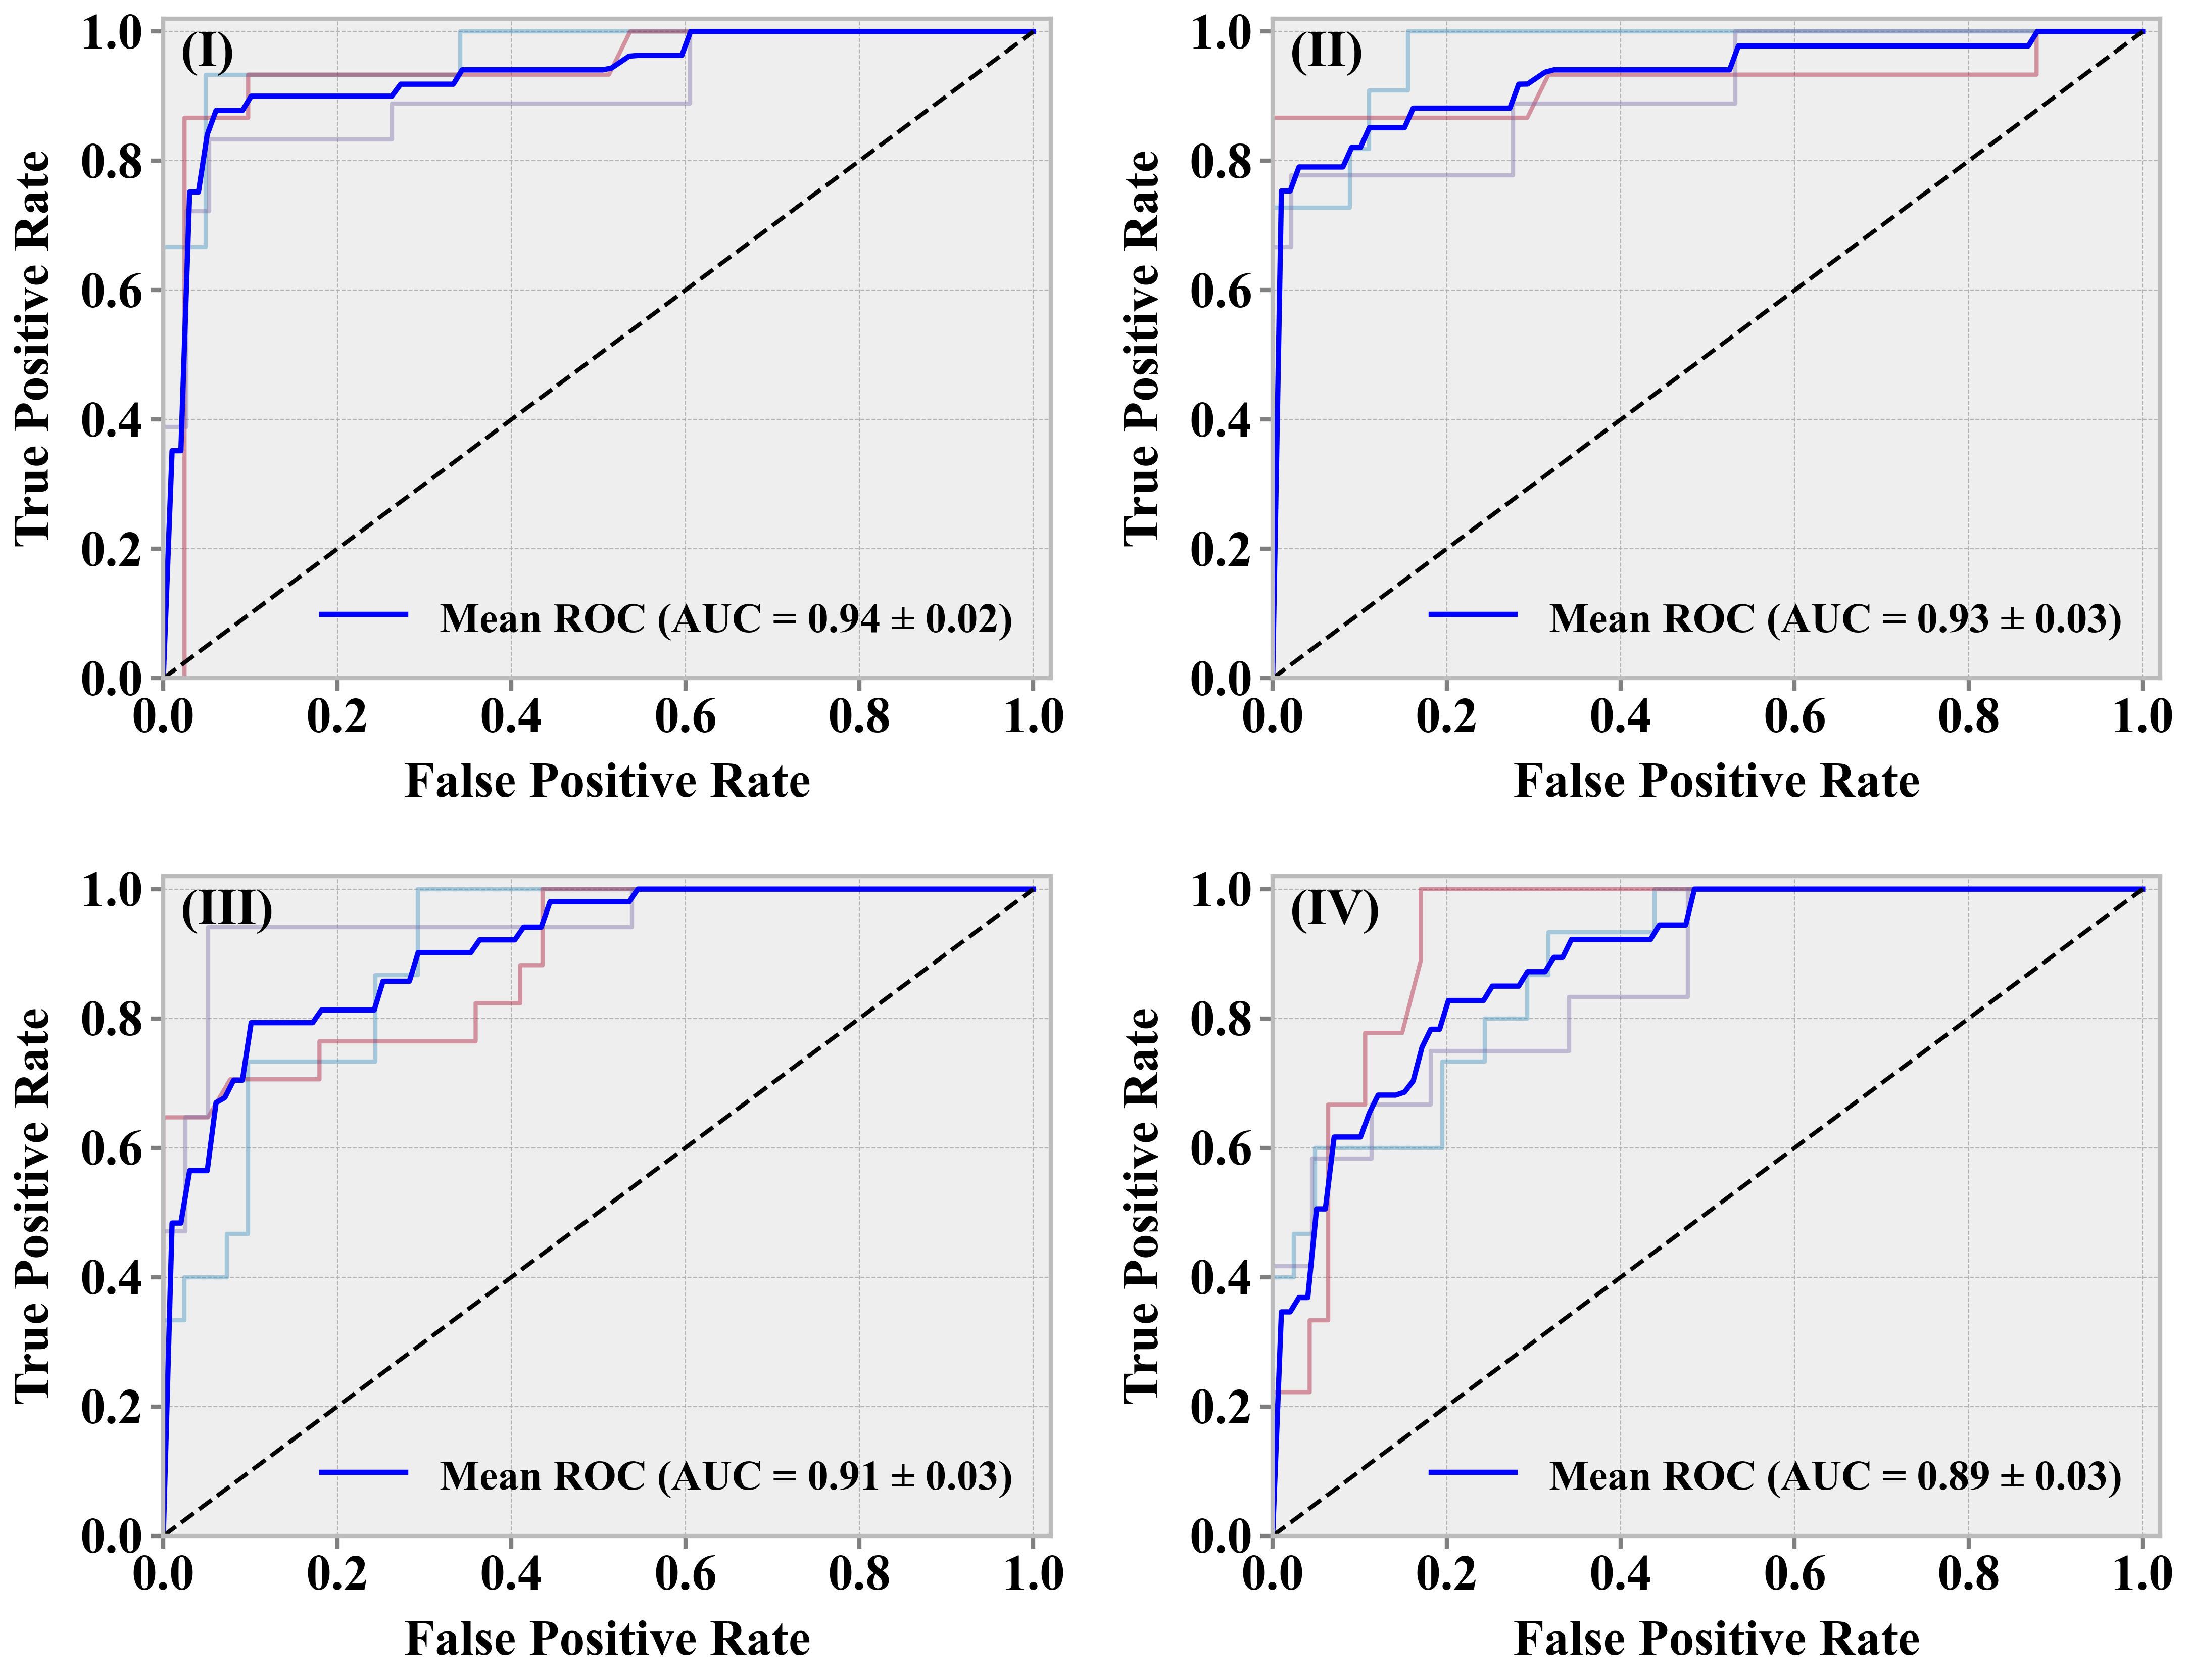

In [21]:
import matplotlib.pyplot as plt
plt.style.use('bmh')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.linewidth'] = 2

fig, axs = plt.subplots(2, 2, figsize=(17, 13), dpi=300)
axs = axs.flatten()

labels = ['(I)', '(II)', '(III)', '(IV)']  # 每个子图标签

for i, q in enumerate(quadrants):
    d = results_all[q]

    # 每折ROC曲线
    for fold_res in d['fold_metrics']:
        axs[i].plot(fold_res['fpr'], fold_res['tpr'], lw=2, alpha=0.4)

    # 平均ROC曲线
    axs[i].plot(d['mean_fpr'], d['mean_tpr'], color='blue', lw=2.5,
                label=f"Mean ROC (AUC = {d['mean_auc']:.2f} ± {d['std_auc']:.2f})")

    axs[i].plot([0, 1], [0, 1], 'k--', lw=2)

    axs[i].set_xlim([0.0, 1.02])
    axs[i].set_ylim([0.0, 1.02])
    axs[i].set_xlabel('False Positive Rate', fontsize=24, fontweight='bold', color='black', labelpad=10)
    axs[i].set_ylabel('True Positive Rate', fontsize=24, fontweight='bold', color='black', labelpad=10)

    axs[i].tick_params(axis='both', which='both', direction='out', length=6, width=2, color='gray', bottom=True, top=False, left=True, right=False)

    # 设置刻度标签字体样式
    for label in axs[i].get_xticklabels() + axs[i].get_yticklabels():
        label.set_fontsize(24)
        label.set_fontweight('bold')
        label.set_fontname('Times New Roman')

    # 添加子图标签
    axs[i].text(0.02, 0.98, labels[i], transform=axs[i].transAxes,
                fontsize=24, fontweight='bold', fontname='Times New Roman',
                verticalalignment='top', horizontalalignment='left')

    axs[i].legend(frameon=False, handlelength=2, handleheight=1,
                  prop={'size': 20, 'weight': 'bold'})

plt.subplots_adjust(hspace=0.3, wspace=0.25)  # hspace 控制上下子图间距，wspace 控制左右子图间距
plt.show()


In [22]:
import pandas as pd

def save_roc_data_to_excel(results_all, quadrants, filename='ROC_Data_All.xlsx'):
    with pd.ExcelWriter(filename, engine='openpyxl') as writer:
        for q in quadrants:
            res = results_all[q]

            # 每折 ROC 数据
            fold_data = []
            for fm in res['fold_metrics']:
                fold = fm['fold']
                for fpr, tpr in zip(fm['fpr'], fm['tpr']):
                    fold_data.append({'Fold': fold, 'FPR': fpr, 'TPR': tpr})
            df_fold = pd.DataFrame(fold_data)
            df_fold.to_excel(writer, sheet_name=f'ROC_Folds_{q}', index=False)

            # 平均 ROC 曲线
            df_mean = pd.DataFrame({
                'FPR': res['mean_fpr'],
                'TPR': res['mean_tpr'],
            })
            df_mean['Mean AUC'] = res['mean_auc']
            df_mean.to_excel(writer, sheet_name=f'ROC_Mean_{q}', index=False)

            # 汇总指标表（含Acc/Prec/Rec/F1/AUC）
            df_metrics = metrics_df_with_mean(res['fold_metrics'])
            df_metrics.to_excel(writer, sheet_name=f'Metrics_{q}', index=False)

    print(f"✅ ROC 曲线和评估指标已保存为 {filename}")

save_roc_data_to_excel(results_all, quadrants, filename='ROC_四个象限.xlsx')

✅ ROC 曲线和评估指标已保存为 ROC_四个象限.xlsx


C:\Users\Administrator\AppData\Local\Temp\ipykernel_27880\181395415.py:99: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Mean' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  mean_row['fold'] = 'Mean'
C:\Users\Administrator\AppData\Local\Temp\ipykernel_27880\181395415.py:99: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Mean' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  mean_row['fold'] = 'Mean'
C:\Users\Administrator\AppData\Local\Temp\ipykernel_27880\181395415.py:99: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Mean' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  mean_row['fold'] = 'Mean'
C:\Users\Administra

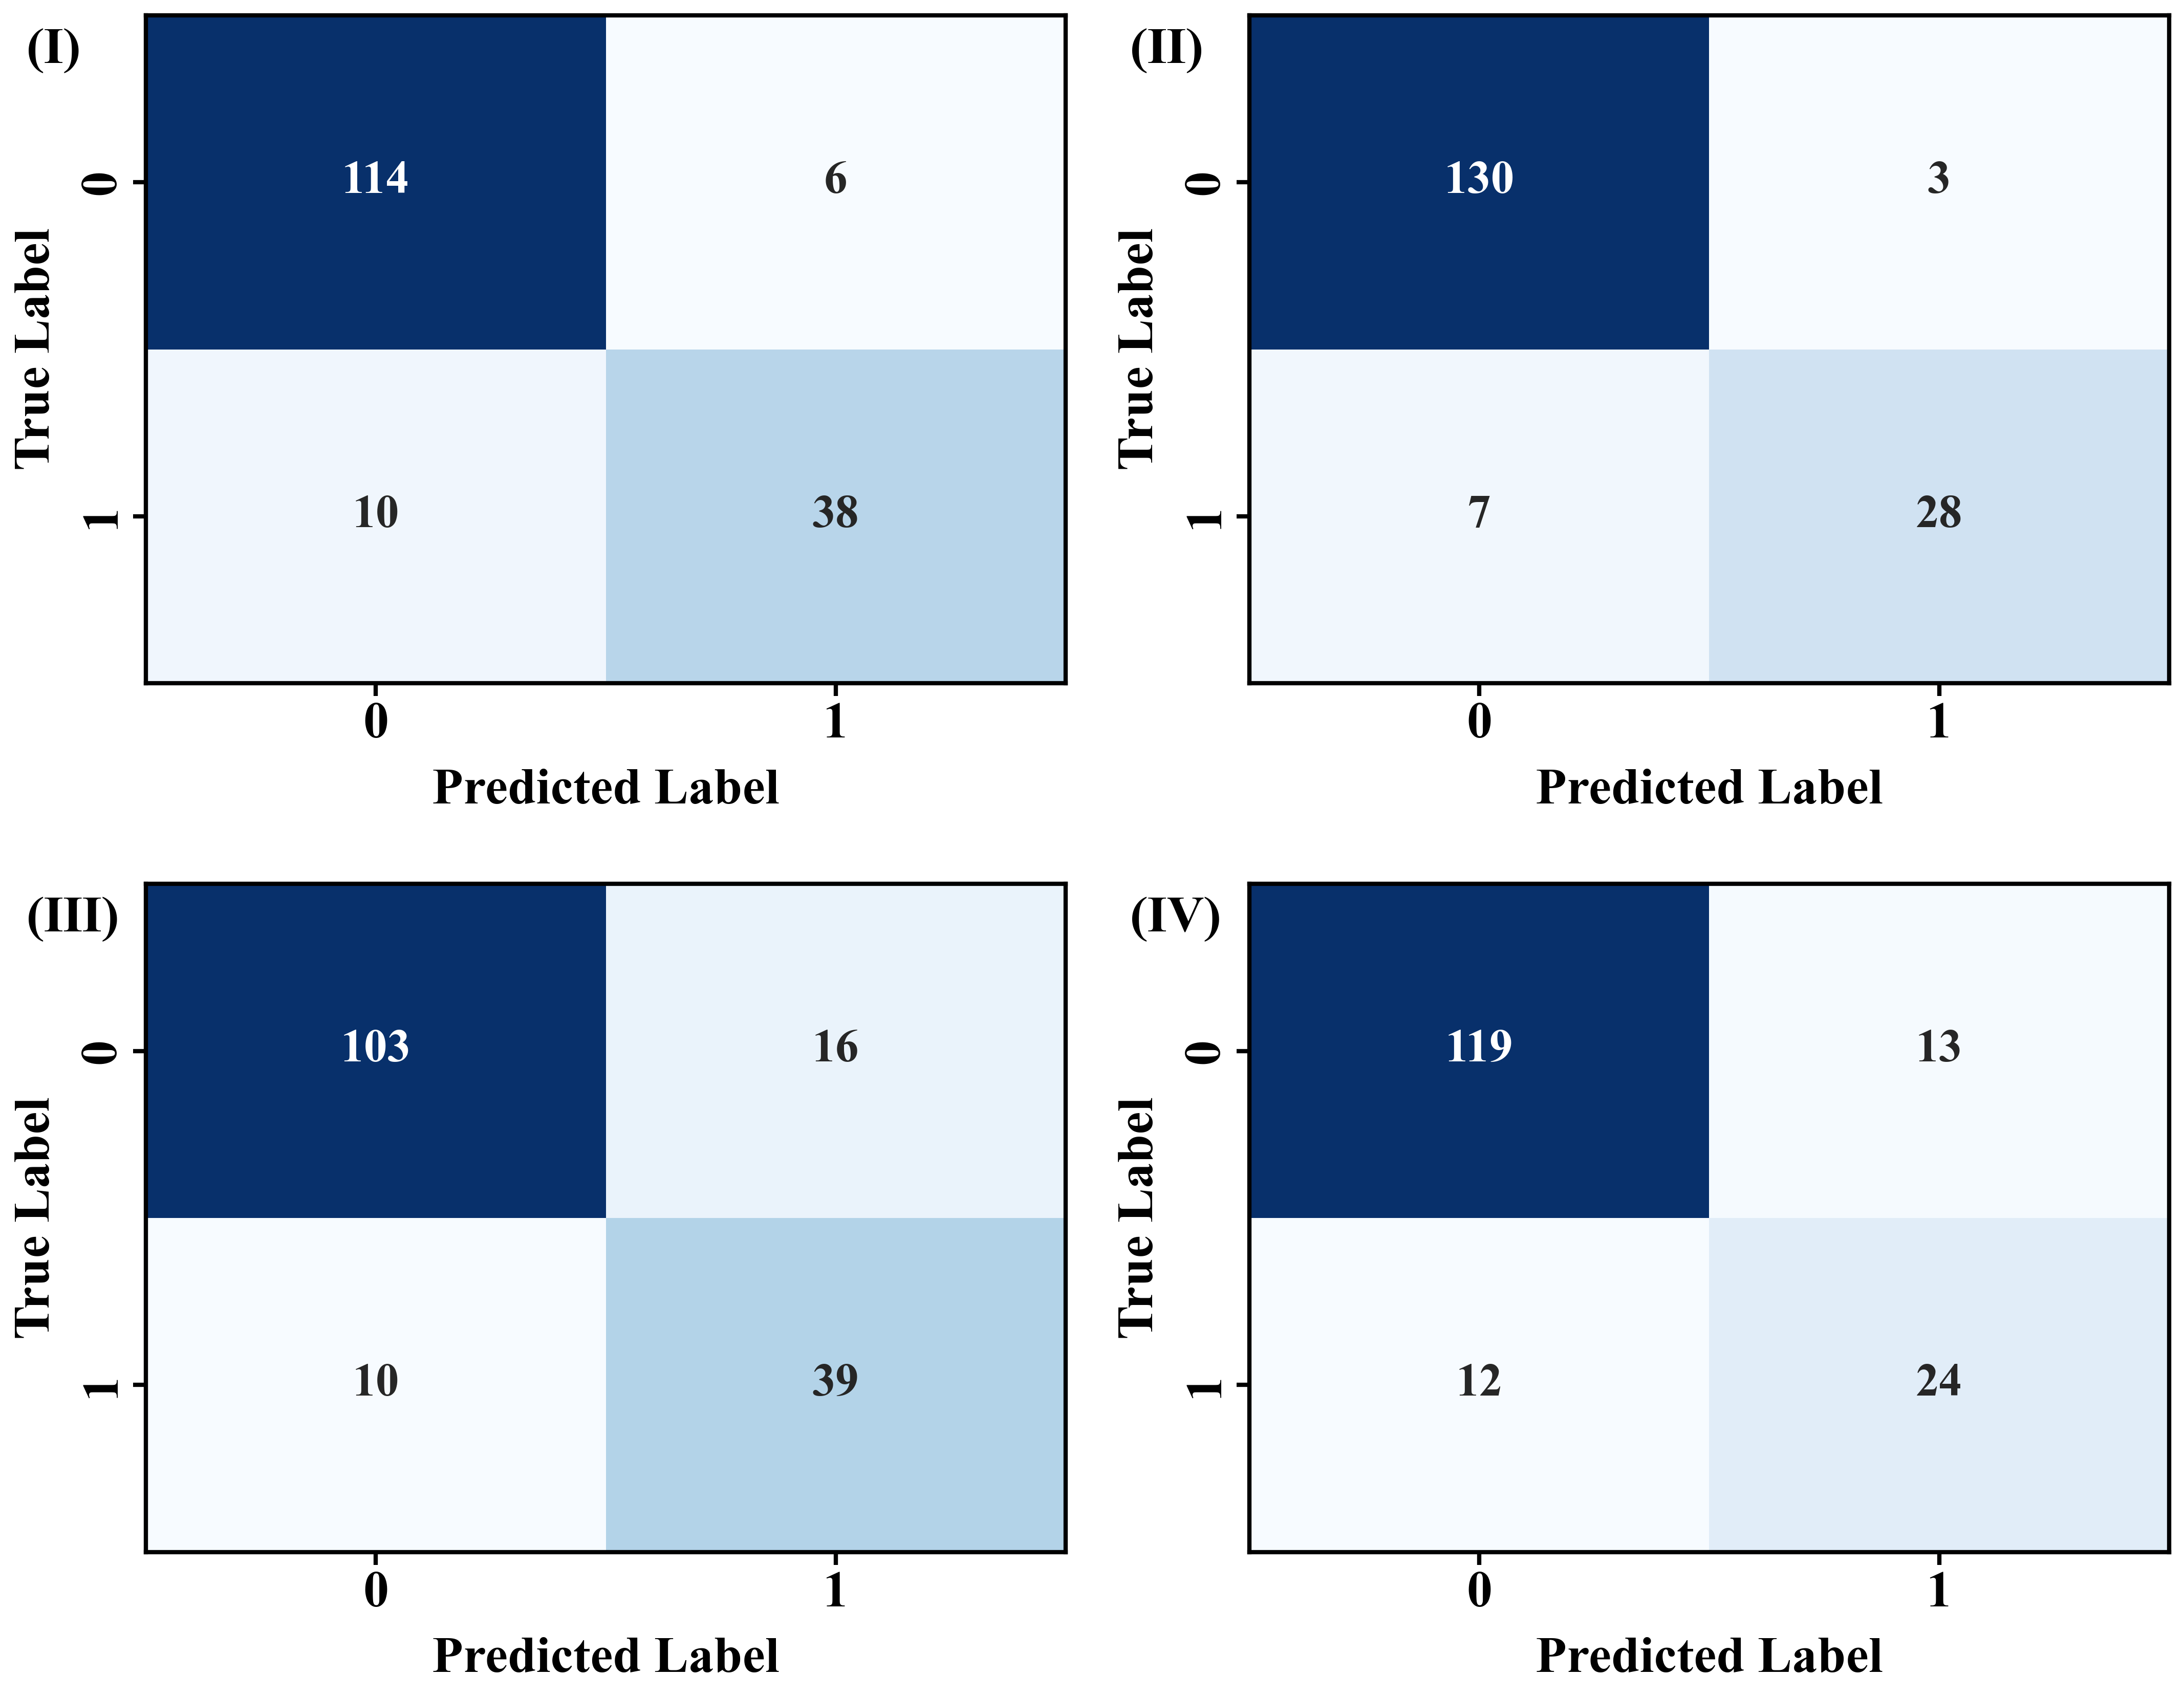

In [23]:
from sklearn.metrics import confusion_matrix
# 计算混淆矩阵
confusion_matrices = {}
for q in quadrants:
    cm = results_all[q]['confusion_matrix']
    confusion_matrices[q] = cm

fig, axs = plt.subplots(2, 2, figsize=(17, 13), dpi=300)
axs = axs.flatten()

labels = ['(Ⅰ)', '(Ⅱ)', '(Ⅲ)', '(Ⅳ)']

for i, q in enumerate(quadrants):
    sns.heatmap(confusion_matrices[q], annot=True, fmt='d', cmap='Blues',
                ax=axs[i], cbar=False, linewidths=0, linecolor='white',
                annot_kws={"size": 22, "weight": "bold", "fontname": "Times New Roman"},
                square=False)

    axs[i].set_xlabel("Predicted Label", fontsize=24, fontweight='bold', fontname='Times New Roman', labelpad=10)
    axs[i].set_ylabel("True Label", fontsize=24, fontweight='bold', fontname='Times New Roman', labelpad=10)

    axs[i].tick_params(axis='both', which='both',
                       direction='out', length=6, width=2, color='black',
                       bottom=True, top=False, left=True, right=False)

    for label in axs[i].get_xticklabels() + axs[i].get_yticklabels():
        label.set_fontsize(24)
        label.set_fontweight('bold')
        label.set_fontname('Times New Roman')

    for _, spine in axs[i].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(2)
        spine.set_color('black')

    axs[i].text(-0.13, 0.98, labels[i], transform=axs[i].transAxes,
                fontsize=24, fontweight='bold', fontname='Times New Roman',
                verticalalignment='top', horizontalalignment='left')
    
    axs[i].grid(False)  

plt.subplots_adjust(hspace=0.3, wspace=0.2)  # hspace 控制上下子图间距，wspace 控制左右子图间距
plt.show()


== 计算 ++ 象限的 SHAP 值 ==
== 计算 -+ 象限的 SHAP 值 ==
== 计算 -- 象限的 SHAP 值 ==
== 计算 +- 象限的 SHAP 值 ==


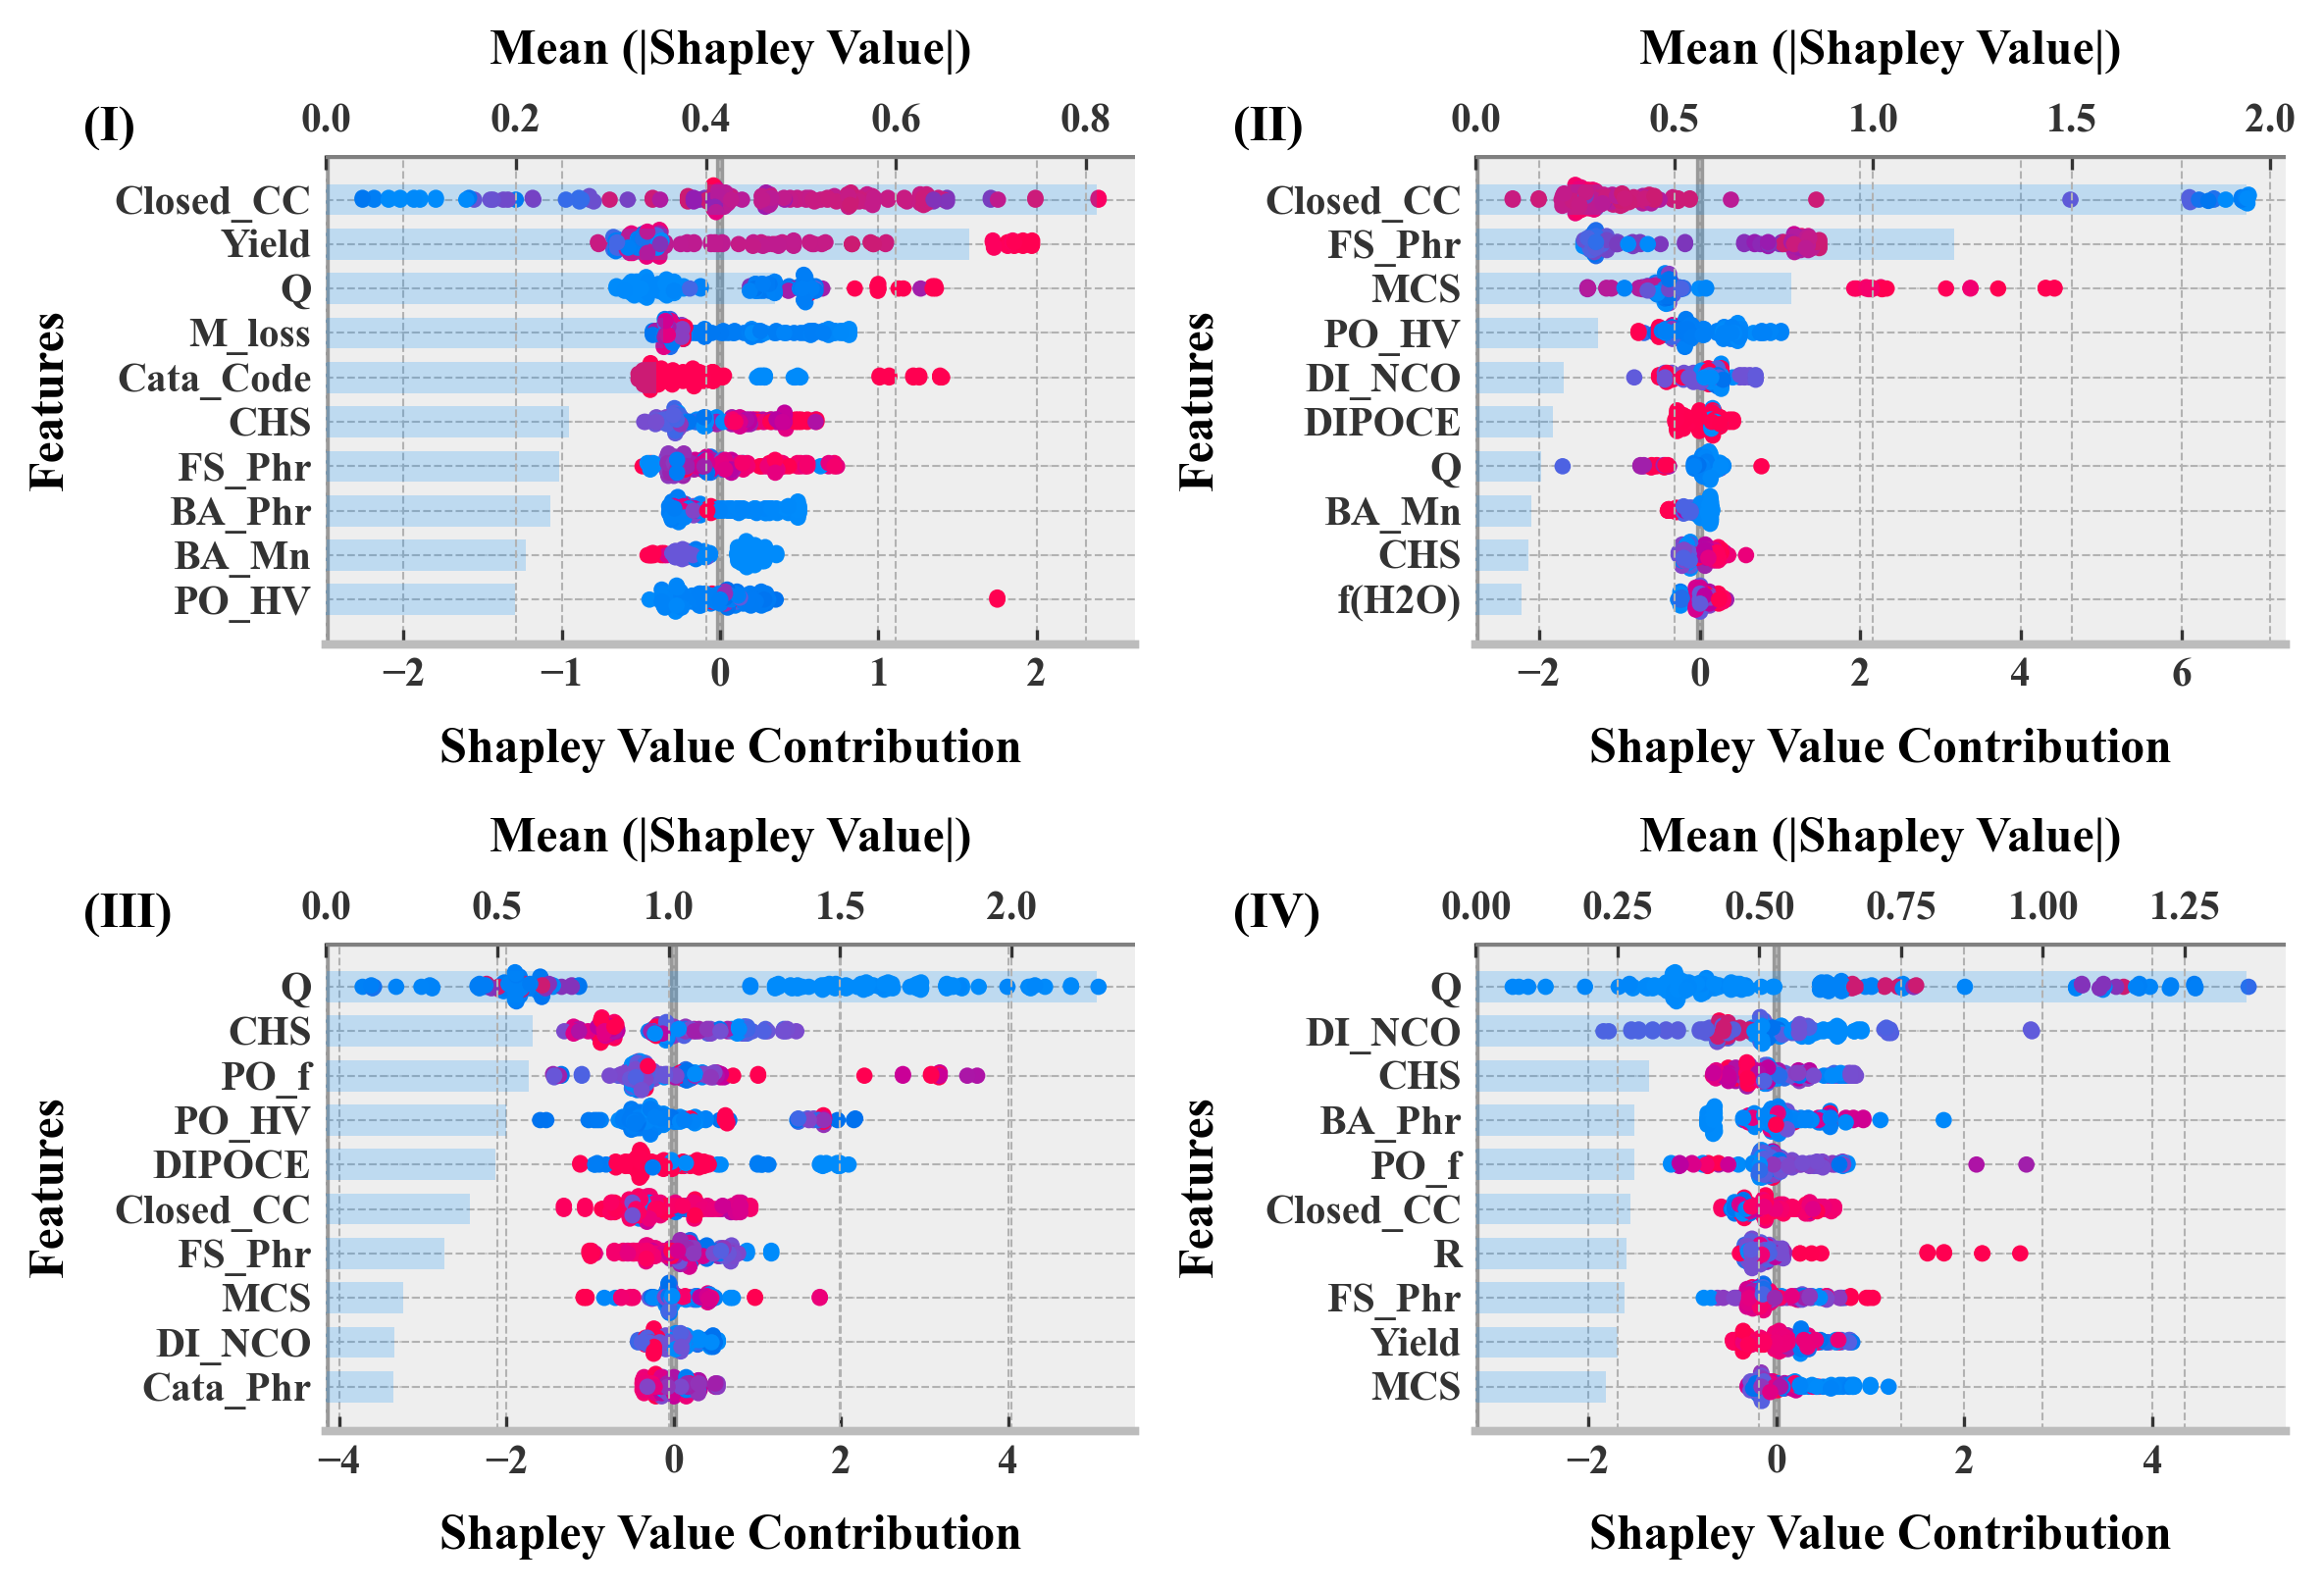

In [24]:
import shap
# ==== 计算 SHAP 值 ====
shap_values_dict = {}
feature_data_dict = {}
for q in quadrants:
    print(f"== 计算 {q} 象限的 SHAP 值 ==")
    X, y = load_data(q)
    params = load_params(q)

    # 重新训练模型以获取 SHAP 值
    model = CatBoostClassifier(
        **params,
        random_state=42,
        thread_count=1,
        verbose=0
    )
    model.fit(X, y)

    # 计算 SHAP 值
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)

    # 保存 SHAP 值和特征数据
    shap_values_dict[q] = shap_values
    feature_data_dict[q] = X
# ==== 绘制 SHAP 值图 ====
# 设置全局字体和样式
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.size'] = 10
plt.style.use('bmh')

# 创建2×2子图
fig, axes = plt.subplots(2, 2, figsize=(20, 18), dpi=300)
axes = axes.flatten()
labels = ['(Ⅰ)', '(Ⅱ)', '(Ⅲ)', '(Ⅳ)']

for i, q in enumerate(quadrants):
    shap_values = shap_values_dict[q]
    X_q = feature_data_dict[q]

    # 设置当前子图
    plt.sca(axes[i])

    # SHAP dot plot
    shap.summary_plot(shap_values, X_q, feature_names=X_q.columns, plot_type="dot", show=False, color_bar=False, max_display=10)

    # 获取 dot plot 的坐标轴
    ax1 = plt.gca()

    # 在同一个子图上创建 twiny 轴用于 bar plot
    ax2 = ax1.twiny()
    shap.summary_plot(shap_values, X_q, feature_names=X_q.columns, plot_type="bar",  show=False,  max_display=10)

    # 添加灰色参考线
    ax2.axhline(y=10, color='gray', linestyle='-', linewidth=2)

    # 设置透明度
    for bar in ax2.patches:
        bar.set_alpha(0.2)

    # 坐标轴标签
    ax1.set_xlabel('Shapley Value Contribution', fontsize=12, labelpad=8, weight='bold')
    ax1.set_ylabel('Features', fontsize=12, labelpad=10, weight='bold')
    ax2.set_xlabel('Mean (|Shapley Value|)', fontsize=12, labelpad=10, weight='bold')
    ax2.xaxis.set_label_position('top')
    ax2.xaxis.tick_top()

    # 坐标轴刻度字体
    for label in ax1.get_xticklabels() + ax1.get_yticklabels() + ax2.get_xticklabels():
        label.set_fontsize(10)
        label.set_fontweight('bold')
        label.set_fontname('Times New Roman')

    # 添加象限标签
    ax1.text(-0.3, 1.1, labels[i], transform=ax1.transAxes,
             fontsize=12, fontweight='bold', fontname='Times New Roman',
             ha='left', va='top')

# 紧凑布局
plt.tight_layout()
plt.show()
